#### Data 612 - Project 2 : Content-Based and Collaborative Filtering<br>Date: June 18, 2019<br>Team Info: 
+ Christina Valore
+ Juliann McEachern 
+ Rajwant Mishra

<h1 align="center">Goodreads Books Recommender Systems</h1>

## Dataset Selection

Data was obtain from [goodbooks2017](#cite-goodbooks2017). Add more details here:
+  `books`: dataset
+  `book_tags`: dataset
+  `tags`: dataset
+  `ratings`: dataset

In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import surprise
from surprise import KNNWithMeans
from surprise.model_selection import train_test_split
from collections import defaultdict
from surprise import SVD

# Load data from local csv  into pandas dataframe
books = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/books.csv')
book_tags = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/book_tags.csv')
tags = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/tags.csv')
ratings = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/ratings.tar.gz', 
                      compression='gzip')

# Clean ratings data
ratings = ratings.drop('ratings.csv', axis=1)
ratings = ratings[:-1].astype(int)

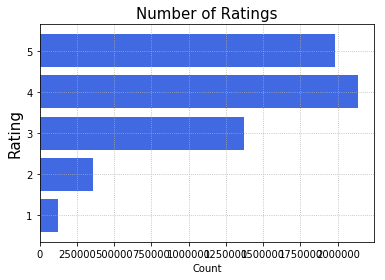

In [320]:
# graph to see the rating scale goes from 1-5, with very few 1 and 2 rating
rts_gp = ratings.groupby(by=['rating']).agg({'user_id': 'count'}).reset_index()
rts_gp.columns = ['Rating', 'Count']

plt.barh(rts_gp.Rating, rts_gp.Count, color='royalblue')
plt.title('Number of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Rating', fontsize=15)
plt.grid(ls='dotted')
plt.show()

In [2]:
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [3]:
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [4]:
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [5]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


## Content-Based Filtering 

Through content-based filtering, we individually filtered user recommendations based on unique, item profiles using our `book`, `book_tag`, and `tags` datasets.

#### Item Profile 

Using a few data transformations, we create individual item profiles, which features include concatenated tags describing each book. 

In [6]:
# CBF Data Cleaning
## select only books writen in english and subset goodreads book id, title, and authors
filter_list = ['eng', 'en-US', 'en-GB', 'en-CA', 'en']
eng_books = books[books.language_code.isin(filter_list)]
subset_books = eng_books[['goodreads_book_id', 'title', 'authors']]

# join tags and books with tags
join_tags = book_tags.set_index('tag_id').join(tags.set_index('tag_id')).drop('count', axis=1)
join_book = pd.merge(subset_books, join_tags, on='goodreads_book_id')
CBF_tags = join_book.groupby(['goodreads_book_id','title','authors'],
                             as_index=False).agg(lambda x:', '.join(x)).rename({'tag_name':'tags'}, axis=1)

We passed the tags column (or profile) as a vector through a term frequency times inverse document frequency (TF-IDF) matrix. This process mines and scores important words from the profile. 

We then created a cosine similiarity matrices for book tags to make our recomendation predictions. Finally, we build a `CBF_recommend function`, which uses the cosine similarities  to identify the top *n* matches for a particular book based solely on it's profile.  

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Generate TF-IDF matrix for tags
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')

# Generate cosine similarity matrix for tags 
tf_idf_matrix = vectorizer.fit_transform(CBF_tags['tags'])
co_sim = linear_kernel(tf_idf_matrix, tf_idf_matrix)

# Create list to match title indices in function
indices = pd.Series(data=CBF_tags.index, index=CBF_tags['title']) 

# Book recommendation function 
def CBF_recommend(title, n):
    if n > 0: # logical statement to ensure valid input for n
        recommendations = CBF_tags[['title', 'authors']] # set recommendation output: title, author
        idx = indices[title] # set index to title
        
        # list and sort similarity scores 
        score = pd.DataFrame(enumerate(co_sim[idx]), columns=['ID', 'score']).drop('ID', axis=1).sort_values('score', ascending = False).iloc[1:,]
  
        # recommend top n books 
        top_n = score[1:n+1]
        test = recommendations.iloc[top_n.index].join(top_n)
        test.index = np.arange(1, len(test) + 1)
        return test
    else: 
        print("Select a value greater than 0 and try again.")

#### Content-Based Filtering Examples

The following examples are used to test our `CBF_recommend function` and view correlation score of recommended books. 

In [8]:
CBF_recommend('To Kill a Mockingbird', 3)

,title,authors,score
1,Of Mice and Men,John Steinbeck,0.520684
2,The Great Gatsby,F. Scott Fitzgerald,0.512877
3,Lord of the Flies,William Golding,0.495521


In [9]:
CBF_recommend('Nineteen Minutes', 3)

,title,authors,score
1,The Tenth Circle,Jodi Picoult,0.352281
2,Salem Falls,Jodi Picoult,0.344941
3,Handle with Care,Jodi Picoult,0.323383


In [10]:
CBF_recommend('A Game of Thrones (A Song of Ice and Fire, #1)', 3)

,title,authors,score
1,"A Feast for Crows (A Song of Ice and Fire, #4)",George R.R. Martin,0.685467
2,"A Dance with Dragons (A Song of Ice and Fire, #5)",George R.R. Martin,0.676265
3,"A Storm of Swords (A Song of Ice and Fire, #3)",George R.R. Martin,0.660945


#### Content-Based Recommendations from User Input 

The `booksearch function` below allows users to search for book titles within our goodbooks compilation. Users can take the output to guide their search for specific item recommendations. 

In [15]:
#pip install fuzzywuzzy
#pip install python-Levenshtein
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

choices = CBF_tags['title']
search_value = input("Search book titles: ")

def booksearch(title):
    fuzzy = process.extract(search_value, choices)
    results = [x[0] for x in fuzzy]
    print("\n".join(str(x) for x in results))

booksearch(search_value)

Search book titles: sun
In a Sunburned Country
The Sun Also Rises
Rising Sun
Sunshine
Half of a Yellow Sun


We also created a `title_recommendations function`, which finds the best title matches from the user's input and runs the selection through our content-based recommender. The user can also select the number of recommendations they wish to receive here. 

In [16]:
title_input = input("Input book title to view recommendations: ")
    
def title_recommendations(title): 
    recommend_n = input("Input number of recommendations you would like to receive: ")
    user_selection = process.extractOne(title_input, choices)[0]
    print("\n Recommending titles based on the book: ",user_selection)
    return CBF_recommend(user_selection, int(recommend_n))

title_recommendations(title_input)

Input book title to view recommendations: sun also rises
Input number of recommendations you would like to receive: 10

 Recommending titles based on the book:  The Sun Also Rises


,title,authors,score
1,The Sound and the Fury,William Faulkner,0.525416
2,To Have and Have Not,Ernest Hemingway,0.505850
3,Tender Is the Night,F. Scott Fitzgerald,0.496121
4,A Room with a View,E.M. Forster,0.492896
5,As I Lay Dying,William Faulkner,0.490031
6,One Flew Over the Cuckoo's Nest,Ken Kesey,0.483343
7,For Whom the Bell Tolls,Ernest Hemingway,0.474811
8,The Grapes of Wrath,John Steinbeck,0.469059
9,The Awakening,Kate Chopin,0.463095
10,An American Tragedy,"Theodore Dreiser, Richard R. Lingeman",0.458220


#### Content-Based Analysis

Upon initial review, the `CBF_recommend` function appears to match book recommendations very effectively based the created item profiles. This method works nicely because it does not require data on other users and does not rate our items based on popularity. 

However, we found this method suffered from a common drawback of the content-based approach, over-specification. Unlike the "To Kill a Mockingbird" recommendations, we see that the top recommender results for "Nineteen Minutes" and "A Game of Thrones" are for other novels written by the same authors as the book we searched for.  

## User-User Collaborative Filtering 

In [317]:
# combined the books and ratings data frames on book_id as that variable is in both datasets
combined = pd.merge(books, ratings, on = 'book_id')
combined.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,user_id,rating
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,2886,5
1,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,6158,5
2,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,3991,4
3,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,5281,5
4,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,5721,5


In [322]:
# subsetting the movie-ratings data to only include columns needed for this analysis
subset_ratings_movies = combined[['book_id', 'user_id','rating', 'title']]
subset_ratings_movies.head()

,book_id,user_id,rating,title
0,1,2886,5,"The Hunger Games (The Hunger Games, #1)"
1,1,6158,5,"The Hunger Games (The Hunger Games, #1)"
2,1,3991,4,"The Hunger Games (The Hunger Games, #1)"
3,1,5281,5,"The Hunger Games (The Hunger Games, #1)"
4,1,5721,5,"The Hunger Games (The Hunger Games, #1)"


In [296]:
# The suprise package does not have native functionality to print out top recommendations, so used the code from ther FAQ section here
# https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-top-n-recommendations-for-each-user

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [285]:
# Set the rating scale from 1 to 5
reader = Reader(rating_scale=(1, 5))
#load the subsetted data from above
data = Dataset.load_from_df(subset_ratings_movies[['user_id', 'book_id', 'rating']], reader)

In [286]:
# create train and test datasets, with the test size at 25% of the original
trainset, testset = train_test_split(data, test_size=0.25)

In [287]:
#check the length of the frame for the value of K which is the sqrt(len)
len(subset_ratings_movies)

688371

In [288]:
# use the KNN with means method to train the model
algo = KNNWithMeans(k=829, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
# check the RMSE for the training set using KNN with means method
print("User-based Model : Training Set")
train_pred = algo.test(trainset.build_testset())
accuracy.rmse(train_pred)

In [290]:
# generate predictions on the test set
predictions = algo.test(testset)

In [298]:
# place predictions into top function to see top 5 predictions per user
top_n = get_top_n(predictions, n=5)

# print recommended top 5 books for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

13084 [25, 27, 4272, 8316, 2]
2056 [6547, 1232, 1267, 143, 1628]
30711 [10, 3596, 544, 27, 184]
5616 [1151, 1181, 1067, 1627, 61]
10457 [3660, 2353, 1029, 24, 21]
39560 [6758, 110, 789, 25, 6256]
25472 [7079, 466, 3631, 4120, 15]
7065 [964, 184, 391, 1530, 117]
26282 [1792, 1310, 39, 4231, 1]
33697 [4405, 189, 110, 192, 157]
3688 [1, 661, 793, 714, 67]
13192 [8619, 4, 85, 734, 1348]
47485 [5682, 3104, 1595, 2649, 1348]
27537 [964, 7398, 466, 3860, 592]
13113 [1723, 463, 6694, 8822, 7132]
27808 [27, 554, 864, 3621, 47]
38362 [250, 2227, 921, 774, 8866]
8749 [27, 24, 98, 265, 344]
14385 [3505, 3808, 739, 8906, 291]
42870 [1597, 2652, 47, 133, 10]
5298 [140, 258, 779, 2853, 6985]
9668 [4464, 3321, 3805, 7907, 366]
26930 [18, 21, 135, 2, 9676]
48213 [215, 141, 70, 1328, 1687]
46985 [4, 591, 1151, 270, 3458]
49239 [960, 161, 151, 2764, 6860]
34531 [25, 27, 47, 250, 1099]
11502 [6, 250, 8111, 1, 67]
41926 [2412, 2, 1, 18, 936]
46527 [2969, 4, 7557, 50, 709]
19668 [9516, 2527, 47, 554, 142]
1

24936 [4, 6256, 70, 325, 476]
51965 [31, 39, 2, 4042, 36]
48566 [861, 2, 175, 2767, 159]
37547 [161, 2027, 24, 1738, 189]
35620 [840, 734, 225, 66, 7]
25000 [2507, 746, 554, 4471, 9835]
4128 [143, 47, 1252, 196, 1212]
1225 [8998, 740, 6644, 6500, 37]
9696 [4653, 493, 265, 59, 36]
14681 [3086, 3660, 894, 3395, 1924]
27103 [11, 4401, 258, 2707, 374]
8691 [6842, 1410, 512, 545, 59]
35780 [9091, 2424, 5991, 87, 4271]
45025 [1275, 135, 1026, 141, 864]
51606 [25, 85, 3986, 2853, 1492]
24326 [463, 1545, 102, 712, 998]
19268 [6337, 5123, 7978, 2288, 265]
24176 [2869, 4, 325, 3091, 291]
589 [135, 760, 25, 2975, 2313]
11287 [8517, 1630, 3341, 1394, 225]
11209 [70, 949, 9157, 488, 18]
43836 [3673, 1905, 3408, 27, 2614]
4975 [18, 2, 87, 215, 446]
52051 [2579, 25, 1, 458, 39]
31972 [3754, 39, 789, 512, 7638]
12810 [25, 18, 24, 23, 157]
29517 [562, 1808, 1014, 789, 9410]
10120 [18, 25, 1480, 161, 70]
21439 [267, 4774, 523, 5999, 225]
51511 [7914, 27, 472, 8019, 225]
33547 [2093, 9257, 389, 165, 1346

5610 [24, 27, 21, 102, 23]
29388 [3172, 50, 31, 59, 2441]
11539 [912, 161, 1821, 1694, 996]
8831 [6419, 4498, 735, 4574, 4922]
44243 [2149, 192, 2412, 5337, 1424]
4241 [155, 5895, 610, 1441, 291]
1711 [8965, 251, 540, 225, 740]
4061 [143, 1275, 840, 50, 168]
46926 [307, 446, 6650, 102, 19]
19582 [6857, 3104, 7909, 3379, 4476]
36031 [9276, 27, 1472, 1, 47]
31522 [5399, 9753, 627, 4180, 339]
6996 [6189, 1274, 3858, 894, 296]
39379 [2, 39, 67, 554, 515]
4470 [4047, 1519, 985, 276, 110]
36121 [1342, 1956, 1, 168, 2]
28984 [1265, 31, 291, 2834, 5101]
39703 [877, 765, 391, 116, 353]
10938 [5827, 2556, 21, 364, 189]
49184 [27, 23, 678, 2571, 374]
4929 [7401, 1310, 5934, 2363, 3957]
41834 [13, 192, 466, 307, 1230]
9123 [31, 652, 87, 157, 98]
24335 [47, 168, 1545, 31, 11]
13137 [366, 10, 70, 15, 11]
6875 [2804, 3198, 7228, 1065, 3494]
13669 [6990, 267, 4111, 673, 3187]
27181 [192, 746, 189, 2101, 1158]
22049 [8437, 4090, 2753, 3582, 18]
28115 [161, 6431, 1023, 528, 276]
40897 [5241, 8203, 2812,

In [300]:
# check the RMSE for the test set using KNN with means method
print("User-based Model : Test Set")
accuracy.rmse(predictions, verbose=True)

User-based Model : Test Set
RMSE: 0.8400


0.8400235079048435

In [311]:
# refit the model using the SVD method
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD()
algo.fit(trainset)

In [312]:
predictions = algo.test(testset)

In [313]:
# checke the RMSE for the test set using the SVD model
print("User-based Model : Test Set")
accuracy.rmse(predictions, verbose=True)

User-based Model : Test Set
RMSE: 0.8541


0.8541369001824354

## Item-Item Collaborative Filtering 

## Summary
Please provide at least one graph, and a textual summary of your findings and recommendations. 

## Sources

**To do: figure out jupyter nbconvert citations**

http://fastml.com/goodbooks-10k-a-new-dataset-for-book-recommendations/

@article{goodbooks2017,
    author = {Zajac, Zygmunt},
    title = {Goodbooks-10k: a new dataset for book recommendations},
    year = {2017},
    publisher = {FastML},
    journal = {FastML},
    howpublished = {\url{http://fastml.com/goodbooks-10k}},
},
